## PDI - Rebalancing data for September 2022

## Setting

In [4]:
import pandas as pd
import numpy as np
import requests

In [5]:
import time

In [6]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [7]:
from defillama import DefiLlama
llama = DefiLlama()

In [8]:
import plotly.express as px
import plotly.graph_objects as go

/home/evgeniy/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

## Data retrieving and filtering

### Token inclusion criteria

1. **Project and token characteristics** 
    1. The project must have a listing on Defi Llama
    1. The project’s token should have been listed on CoinGecko with pricing data at least 1 year prior to the date of inclusion in the index. 
    1. The project should have a token that is native to Ethereum L1 or L2. This excludes wrapped variants, where the underlying tokens are locked on an alt-L1.
    1. The project should be a going concern, with a dedicated team actively building, supporting and maintaining the project. 
    1. No rebasing or deflationary tokens.
    1. The project must be widely considered to be building a useful protocol or product. Projects that have ponzi characteristics at the core of their offering will not be considered.
    1. Synthetic tokens which derive their value from external price feeds are not permissible. 
    1. The project’s token must not have the ability to pause token transfers.
    1. The project’s protocol or product must have significant usage.
    
    
1. **Token Supply requirements**
    1. The project's token must have a circulating supply greater than 30% of the max supply. In cases where a token does not have a max supply, the minting mechanics would need to be assessed.
    1. The token must not have locking, minting or other patterns that would significantly disadvantage passive holders.


1. **Liquidity Requirements**
    1. The token must be listed on a supported exchange.
    1. The token should have in aggregate at least $5mm of onchain liquidity across Uniswap v2, Uniswap v3, Sushiswap, Balancer v1, Balancer v2, Bancor v2 and Bancor v3.
    1. The token must have shown consistent DeFi liquidity on Ethereum.


1. **Security Requirements**
    1. The project must have been audited by smart contract security professionals with the audit report(s) publicly available. Alternatively, the protocol must have been operating long enough to create a consensus about its safety in the decentralised finance community.

### Tokens list

In [10]:
def normalize_symb(symb):
    return ''.join(c for c in symb if c.isalnum()).upper()

#### DefiLlama

In [11]:
protocols = llama.get_all_protocols()

In [12]:
top_defi_tokens = {} 
for pr in protocols[:1000]:
    if 'Ethereum' in pr['chains'] and pr['address'] and pr['address']!='-' and pr['symbol'] != '-':
        symbol = normalize_symb(pr['symbol']) 
        address = pr['address'].lower().split(":")[-1]
        top_defi_tokens[symbol] = {
            'symbol': symbol, 
            'address': address 
        }

#### CoinGecko

##### Tokens addresses

In [13]:
coins_list = pd.DataFrame(cg.get_coins_list(include_platform=True))

In [14]:
tokens = {} 
tokens_by_addr = {}
for index, coin in coins_list.iterrows():
    if len(coin['platforms']) >= 1 and 'ethereum' in list(coin['platforms'].keys()):
        symbol = normalize_symb(coin['symbol'])
        address = coin['platforms']['ethereum'].lower().split(":")[-1]
        token = {
            'symbol': symbol,
            'address': address 
        }
        tokens[symbol] = token
        tokens_by_addr[address] = token

In [15]:
tokens['USDC'], tokens['WETH']

({'symbol': 'USDC', 'address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'},
 {'symbol': 'WETH', 'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'})

In [16]:
# These token's addresses cant be found in the coingecko list of eth addresses
exclude_symbols = []
for symb, token in top_defi_tokens.items():
    if token['address'] not in tokens_by_addr.keys():
        # print(token)
        exclude_symbols.append(token['symbol'])

In [17]:
for symb in exclude_symbols:
    del top_defi_tokens[symb]

##### Market data

In [18]:
cg_tokens_data = cg.get_coins_markets(vs_currency='USD', order='market_cap_desc')
for i in range(2, 20):
    cg_tokens_data.extend(cg.get_coins_markets(vs_currency='USD', order='market_cap_desc', page=i))
    
cg_tokens_data = pd.DataFrame.from_records(cg_tokens_data)

In [19]:
tokens_market_data = cg_tokens_data.set_index(cg_tokens_data['symbol'].str.upper())

In [20]:
duplicated = tokens_market_data.index[tokens_market_data.index.duplicated(keep='first')]
tokens_market_data = tokens_market_data.drop(index=duplicated)

In [21]:
tokens_market_data = tokens_market_data.rename(index={"ETH": "WETH"})

### Token's supply check 

In [22]:
sp_passed_index = (tokens_market_data['circulating_supply'] / tokens_market_data['total_supply']) > 0.3
sp_passed = tokens_market_data[sp_passed_index]

### Liquidity check

In [23]:
api_urls = {
    'univ2': "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2",
    'univ3': "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3",
    'sushi': "https://api.thegraph.com/subgraphs/name/sushiswap/exchange",
    'bancorv2': "https://api-v2.bancor.network/tokens",
    'bancorv3': "https://api-v3.bancor.network/pools",
    'balancer': "https://api.thegraph.com/subgraphs/name/balancer-labs/balancer",
    'balancerv2': "https://api.thegraph.com/subgraphs/name/balancer-labs/balancer-v2" 
} 

In [24]:
def univ2_get_liquidities(tokens_ids):
    query = """
        query pairs($tokens_ids: [ID!]!) {
            pairs (first:1000, 
                where: {
                    token0_in: $tokens_ids, 
                    token1_in: $tokens_ids,
                    reserveUSD_gt: 10000
                }){
                token0 {
                    id
                    symbol
                }
                token1 {
                    id
                    symbol
                }
                reserveUSD
            }
        }
    """
    url = api_urls['univ2']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    pairs = response.json()['data']['pairs']
    
    liqs = {}
    for pair in pairs:
        liq = float(pair['reserveUSD'])
        
        symb0 = normalize_symb(pair['token0']['symbol'])
        if symb0 in tokens_market_data.index and pair['token0']['id'].lower() in tokens_ids:
            liqs[symb0] = liqs.get(symb0, 0) + liq
        
        symb1 = normalize_symb(pair['token1']['symbol'])
        if symb1 in tokens_market_data.index and pair['token1']['id'].lower() in tokens_ids:
            liqs[symb1] = liqs.get(symb1, 0) + liq 
        
    return liqs
    

In [25]:
def univ3_get_liquidities(tokens_ids):
    query = """
        query pools($tokens_ids: [ID!]!) {
            pools (first:1000, 
                where: {
                    token0_in: $tokens_ids, 
                    token1_in: $tokens_ids,
                    totalValueLockedUSD_gt: 10000
                }){
                token0 {
                    id
                    symbol
                } 
                token1 {
                    id
                    symbol
                }
                totalValueLockedUSD
            }
        }
    """
    url = api_urls['univ3']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    pools = response.json()['data']['pools']
    
    liqs = {}
    for pool in pools:
        liq = float(pool['totalValueLockedUSD'])
        
        symb0 = normalize_symb(pool['token0']['symbol'])
        if symb0 in tokens_market_data.index and pool['token0']['id'].lower() in tokens_ids:
            liqs[symb0] = liqs.get(symb0, 0) + liq 
        
        symb1 = normalize_symb(pool['token1']['symbol'])
        if symb1 in tokens_market_data.index and pool['token1']['id'].lower() in tokens_ids:
            liqs[symb1] = liqs.get(symb1, 0) + liq 
            
    return liqs
    

In [26]:
def sushi_get_liquidities(tokens_ids):
    query = """
        query pairs($tokens_ids: [ID!]!) {
            pairs (first:1000, 
                where: {
                    token0_in: $tokens_ids, 
                    token1_in: $tokens_ids,
                    reserveUSD_gt: 10000
                }){
                token0 {
                    id
                    symbol
                }
                token1 {
                    id
                    symbol
                }
                reserveUSD
            }
        }
    """
    url = api_urls['sushi']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    pairs = response.json()['data']['pairs']
    
    liqs = {}
    for pair in pairs:
        liq = float(pair['reserveUSD'])
        
        symb0 = normalize_symb(pair['token0']['symbol'])
        if symb0 in tokens_market_data.index and pair['token0']['id'].lower() in tokens_ids:
            liqs[symb0] = liqs.get(symb0, 0) + liq
        
        symb1 = normalize_symb(pair['token1']['symbol'])
        if symb1 in tokens_market_data.index and pair['token1']['id'].lower() in tokens_ids:
            liqs[symb1] = liqs.get(symb1, 0) + liq
        
    return liqs
    

In [27]:
def bancorv2_get_liquidities(tokens_ids):
    url = api_urls['bancorv2'] 
    response = requests.get(url)
    tokens = response.json()['data']
    
    liqs = {}
    for token in tokens:
        if token['dlt_id'].lower() in tokens_ids:
            symb = normalize_symb(token['symbol'])
            liqs[symb] = float(token['liquidity']['usd'])
            
    return liqs
            

In [28]:
def bancorv3_get_liquidities(tokens_ids):
    url = api_urls['bancorv3'] 
    response = requests.get(url)
    pools = response.json()['data']
    
    liqs = {}
    for pool in pools:
        if pool['poolDltId'].lower() in tokens_ids:
            symb = normalize_symb(pool['name'])
            liqs[symb] = liqs.get(symb, 0) + float(pool['liquidity']['usd'])
            
    return liqs
            

In [29]:
def balancer_get_liquidities(tokens_ids):
    query = """
        query pools {
            pools (
                first: 1000,
                where: {
                  liquidity_gt: 10000
                }
            ){
                tokens {
                  address
                  symbol
                  balance
                }
                liquidity
          }
        }
    """
    url = api_urls['balancer']
    
    response = requests.post(url, json={'query': query})
    pools = response.json()['data']['pools']
    
    liqs = {}
    for pool in pools:
        liq = 0
        for token in pool['tokens']:
            symb = normalize_symb(token['symbol'])
            if symb in tokens_market_data.index: 
                liq += float(token['balance']) * tokens_market_data.loc[symb]['current_price']
            
        for token in pool['tokens']:
            symb = normalize_symb(token['symbol'])
            if symb not in tokens_market_data.index or token['address'].lower() not in tokens_ids:
                continue
                
            liqs[symb] = liqs.get(symb, 0) + liq
        
    return liqs
    

In [30]:
def balancerv2_get_liquidities(tokens_ids):
    query = """
        query pools {
            pools (
                first: 1000,
                where: {
                  totalLiquidity_gt: 10000
                }
            ){
                tokens {
                  address
                  symbol
                  balance
                }
                totalLiquidity
          }
        }
    """
    url = api_urls['balancerv2']
    
    response = requests.post(url, json={'query': query})
    pools = response.json()['data']['pools']
    
    liqs = {}
    for pool in pools:
        liq = float(pool['totalLiquidity'])
        
        for token in pool['tokens']:
            symb = normalize_symb(token['symbol'])
            if symb not in tokens_market_data.index or token['address'].lower() not in tokens_ids:
                continue
            
            liqs[symb] = liqs.get(symb, 0) + liq 
        
    return liqs
    

In [31]:
tokens['AMP']

{'symbol': 'AMP', 'address': '0xff20817765cb7f73d4bde2e66e067e58d11095c2'}

In [32]:
tokens_ids = [token['address'] for symb, token in top_defi_tokens.items()]

In [33]:
tokens_ids.append(tokens['WETH']['address'])
tokens_ids.append(tokens['USDC']['address'])

In [34]:
query_functions = {
    'univ2': univ2_get_liquidities,
    'univ3': univ3_get_liquidities, 
    'sushi': sushi_get_liquidities, 
    'bancorv2': bancorv2_get_liquidities,
    'bancorv3': bancorv3_get_liquidities,
    'balancer': balancer_get_liquidities, 
    'balancerv2': balancerv2_get_liquidities, 
}

In [35]:
liqs_dict = {}
for dex, func in query_functions.items():
    liqs_dict[dex] = func(tokens_ids)

In [36]:
liquidities = pd.DataFrame.from_dict(liqs_dict)

In [37]:
liquidities['sum'] = liquidities.sum(axis=1)
liquidities.sort_values('sum', ascending=False).head(50)

,univ2,univ3,sushi,bancorv2,bancorv3,balancer,balancerv2,sum
WETH,1.957690e+08,1.150697e+09,1.855795e+08,NaN,NaN,1.181267e+08,5.761510e+08,2.226324e+09
USDC,1.232757e+08,7.575389e+08,6.005250e+07,6.325333e+05,1.640805e+06,1.970214e+07,8.084353e+07,1.043686e+09
WBTC,1.402155e+07,4.181125e+08,2.091098e+07,3.525524e+06,3.615092e+06,4.457905e+06,4.782062e+07,5.124642e+08
BAL,3.079577e+04,3.801030e+05,NaN,0.000000e+00,0.000000e+00,4.190049e+06,1.903055e+08,1.949065e+08
AAVE,2.075298e+05,7.935543e+06,9.154838e+06,1.096193e+05,8.096159e+04,9.993546e+07,1.972816e+04,1.174437e+08
UNI,2.031983e+07,1.892879e+07,4.102079e+05,1.056955e+05,4.189989e+04,1.069297e+05,1.895642e+06,4.180900e+07
LDO,2.071679e+05,1.401712e+07,8.153617e+06,NaN,NaN,NaN,9.731153e+06,3.210906e+07
BADGER,9.040158e+05,6.901082e+06,1.335261e+06,NaN,NaN,NaN,1.926146e+07,2.840182e+07
BNT,1.305721e+04,NaN,NaN,2.652630e+07,NaN,NaN,NaN,2.653935e+07
MPL,1.837698e+06,1.249902e+06,NaN,NaN,NaN,1.501405e+07,NaN,1.810165e+07


In [38]:
liquidities.loc['AMP']

univ2         103996.019086
univ3         471521.063643
sushi         150223.540455
bancorv2       27112.368926
bancorv3       22388.105437
balancer                NaN
balancerv2              NaN
sum           775241.097547
Name: AMP, dtype: float64

In [39]:
tokens['AMP']

{'symbol': 'AMP', 'address': '0xff20817765cb7f73d4bde2e66e067e58d11095c2'}

In [40]:
liq_check = (liquidities['sum'] > 5e6).sort_values(ascending=False)
liq_check_passed = liq_check[liq_check]

In [41]:
lq_passed = sp_passed[
    sp_passed.index.isin(liq_check_passed.index)
]

In [42]:
# lq_passed

### Non quantative checks

In [95]:
exclude_list = [
    {
        'symbol': 'WBTC',
        'reason': 'Criteria 1.C'
    },
    {
        'symbol': 'WETH',
        'reason': 'Criteria 1.C'
    },
    {
        'symbol': 'ERN',
        'reason': 'Not DeFi'
    },
    {
        'symbol': 'NFTX',
        'reason': 'Not DeFi'
    },
    {
        'symbol': 'FXS',
        'reason': 'Criteria 1.G'
    },
    {
        'symbol': 'RGT',
        'reason': 'Deprecated asset'
    },
    {
        'symbol': 'SUPER',
        'reason': 'Not DeFi'
    },
    {
        'symbol': 'BOND',
        'reason': 'Criteria 1.I'
    },
    {
        'symbol': 'USDC',
        'reason': 'stable'
    },
    {
        'symbol': 'FEI',
        'reason': 'stable'
    },
    {
        'symbol': 'BNT',
        'reason': 'Token has a circular feedback loop with current ILP implementation'
    },
    {
        'symbol': 'SYN',
        'reason': 'bridge'
    }
    
]
exclude_symbols = [token['symbol'] for token in exclude_list]

In [96]:
nq_passed = lq_passed[
    ~lq_passed.index.isin(exclude_symbols)
]

In [97]:
# nq_passed

### Retrieve historical data & livetime check

In [98]:
time.sleep(1)

exclude_list = []

prices_data = pd.DataFrame()
marketcaps = pd.DataFrame() 
for index, data in nq_passed[['id', 'symbol']].iterrows():
    id_ = data['id']
    symbol = data['symbol'].upper()
    data = cg.get_coin_market_chart_by_id(id_, vs_currency='USD', days='max')
  
    df_prices = pd.DataFrame(data['prices'], columns=['date', symbol])
    df_prices = df_prices[df_prices[symbol] > 0]
    df_prices['date'] = pd.to_datetime(df_prices['date'], unit='ms').dt.date
    df_prices['date'] = pd.to_datetime(df_prices['date'])
    df_prices = df_prices.set_index('date', drop=True)
    df_prices = df_prices.loc[~df_prices.index.duplicated(keep='first')]
    
    if len(df_prices) < 365:
        print(f'Excluding {symbol}, prices data available only for {len(df_prices)} < 365 days')
        exclude_list.append(symbol)
        continue
    prices_data = pd.concat([prices_data, df_prices], axis=1)
    
    df_mcaps = pd.DataFrame(data['market_caps'], columns=['date', symbol])
    df_mcaps = df_mcaps[df_mcaps[symbol] > 0]
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'], unit='ms').dt.date
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'])
    df_mcaps = df_mcaps.set_index('date', drop=True)
    df_mcaps = df_mcaps.loc[~df_mcaps.index.duplicated(keep='first')]
    
    if len(df_mcaps) < 365:
        print(f'Note: {symbol}, marketcap data available only for {len(df_mcaps)} < 365 days')
        ## continue
    df_mcaps = df_mcaps.reindex(df_prices.index)
    marketcaps = pd.concat([marketcaps, df_mcaps], axis=1)
    
    

Excluding TEMPLE, prices data available only for 242 < 365 days


In [99]:
lt_passed = nq_passed[
    ~nq_passed.index.isin(exclude_list)
]

In [100]:
lt_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,6.310000,2883119958,28,6.315850e+09,78620736.0,6.530000,...,1.000000e+09,1.000000e+09,44.92,-85.93688,2021-05-03T05:25:04.822Z,1.030000,513.18774,2020-09-17T01:20:38.214Z,None,2022-09-05T08:50:44.857Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,87.880000,1233227871,47,1.408300e+09,88990079.0,89.640000,...,1.600000e+07,1.600000e+07,661.69,-86.69628,2021-05-18T21:19:59.514Z,26.020000,238.27337,2020-11-05T09:20:11.928Z,None,2022-09-05T08:50:37.629Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,1.940000,1174276266,48,1.943500e+09,53631745.0,2.070000,...,1.000000e+09,1.000000e+09,7.30,-73.40660,2021-08-20T08:35:20.158Z,0.406150,378.16888,2022-06-18T20:55:12.035Z,None,2022-09-05T08:50:32.558Z
SNX,havven,snx,Synthetix Network,https://assets.coingecko.com/coins/images/3406...,2.950000,700428384,67,8.721540e+08,34816179.0,3.000000,...,2.948452e+08,2.948452e+08,28.53,-89.63320,2021-02-14T01:12:38.505Z,0.034786,8402.99373,2019-01-06T00:00:00.000Z,"{'times': 4.90558687150441, 'currency': 'usd',...",2022-09-05T08:50:52.585Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,747.260000,673793309,72,7.517395e+08,27928311.0,755.630000,...,9.776310e+05,1.005577e+06,6292.31,-88.11931,2021-05-03T21:54:29.333Z,168.360000,344.03724,2020-03-16T20:52:36.527Z,None,2022-09-05T08:50:39.515Z
RPL,rocket-pool,rpl,Rocket Pool,https://assets.coingecko.com/coins/images/2090...,24.160000,392133106,106,4.359241e+08,1363270.0,24.370000,...,1.800000e+07,1.800000e+07,59.46,-59.28269,2021-11-09T04:03:31.003Z,0.008847,273533.14606,2018-08-28T00:00:00.000Z,None,2022-09-05T08:50:36.431Z
1INCH,1inch,1inch,1inch,https://assets.coingecko.com/coins/images/1346...,0.662713,386085881,111,9.965623e+08,33243133.0,0.678333,...,1.500000e+09,1.500000e+09,8.65,-92.32562,2021-10-27T08:24:54.808Z,0.519281,27.86117,2022-06-18T20:10:15.819Z,None,2022-09-05T08:50:37.815Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,47.320000,324789643,123,4.737246e+08,17471270.0,48.980000,...,1.000000e+07,1.000000e+07,910.54,-94.79724,2021-05-12T02:29:08.794Z,26.410000,79.37504,2022-06-18T20:54:18.261Z,None,2022-09-05T08:50:38.081Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,9382.950000,296266435,131,3.436558e+08,36095728.0,9564.250000,...,3.666600e+04,3.666600e+04,90787.00,-89.67774,2021-05-12T00:29:37.713Z,31.650000,29513.58752,2020-07-18T12:26:27.150Z,None,2022-09-05T08:50:35.209Z


In [101]:
liquidities.loc[lt_passed.index]

,univ2,univ3,sushi,bancorv2,bancorv3,balancer,balancerv2,sum
symbol,,,,,,,,
UNI,2.031983e+07,1.892879e+07,4.102079e+05,105695.536027,4.189989e+04,1.069297e+05,1.895642e+06,4.180900e+07
AAVE,2.075298e+05,7.935543e+06,9.154838e+06,109619.320896,8.096159e+04,9.993546e+07,1.972816e+04,1.174437e+08
LDO,2.071679e+05,1.401712e+07,8.153617e+06,NaN,NaN,NaN,9.731153e+06,3.210906e+07
SNX,1.806342e+06,3.886650e+06,7.733262e+05,898758.420184,1.197295e+05,2.018806e+05,2.213508e+06,9.900195e+06
MKR,1.640460e+06,1.297915e+07,3.559883e+05,231179.742086,1.055179e+05,4.254439e+05,NaN,1.573774e+07
RPL,NaN,6.612057e+06,NaN,26892.598177,5.459277e+04,NaN,1.574697e+06,8.268239e+06
1INCH,2.410880e+05,1.235848e+07,NaN,1962.076525,0.000000e+00,NaN,NaN,1.260153e+07
COMP,1.586208e+05,7.959513e+06,4.343666e+06,188191.837880,0.000000e+00,4.394559e+04,1.189060e+06,1.388300e+07
YFI,4.400979e+05,1.098070e+06,7.889919e+06,621118.364691,4.740458e+04,4.831035e+04,3.334212e+06,1.347913e+07


### Slippage check

To derive a slippage threshold, consider an abstract univ2-like pool with $5m\$$ overall liquidity. 
I.e if pool has reserves $R_1$, $R_2$ and $p_1$ and $p_2$ are the correspondent tokens prices (in USD), then
$$R_1p_1 = R_2p_2 = 2.5m \$$$

Swapping $x$ token1 for token2 will result in the output amount $y$ such that
$$R_1\cdot R_2 = (R_1 + x) \cdot (R_2 - y)$$
$$y = \frac{R_2\cdot x}{R_1 + x}$$
Then the delivery price will be
$$p_d = \frac{y}{x} = \frac{R_2}{R_1 + x}$$
The spot price may be estimated as a delivery price for relatively small input amount $x_0$
$$p_s = \frac{y_0}{x_0} = \frac{R_2}{R_1 + x_0}$$

Then the theoretical slippage for this pool will be
$$slippage = \frac{p_d}{p_s} - 1 = \frac{R_1+x_0}{R_1+x} - 1 = \frac{p_1R_1+p_1x_0}{p_1R_1+p_1x}-1$$

In [102]:
liq = 5*10**6
liq_os = liq / 2 # one-side liquidity 
trade_value_tiny = 1e3
trade_value = 1e5

In [103]:
max_slippage = (liq_os + trade_value_tiny) / (liq_os + trade_value) - 1
max_slippage

-0.03807692307692312

In [105]:
url_0x = "https://api.0x.org/swap/v1/quote" 

In [106]:
decimals = 18
slippages = []
for symb, data in lt_passed.iterrows():
    query = {
        'buyToken': 'WETH',
        'sellToken': tokens[symb]['address'],
        'sellAmount': int(trade_value_tiny / data['current_price'] * 10 ** decimals),
    }
    
    # spot price is calculated as a price for 1000$ swap
    resp = requests.get(url_0x, params=query)
    swap = resp.json()
    spot_price = float(swap['price'])
    
    query['sellAmount'] = int(trade_value / data['current_price'] * 10 ** decimals)
    resp = requests.get(url_0x, params=query)
    swap = resp.json()
    del_price = float(swap['price'])
    
    slippage = del_price / spot_price - 1
    
    slippages.append({
        'symb': symb,
        'spot_price': spot_price,
        'delivery_price': del_price,
        'slippage': slippage
    })
    
    # time.sleep(1)

In [107]:
slippages_df = pd.DataFrame(slippages)
slippages_df

,symb,spot_price,delivery_price,slippage
0,UNI,3.981577e-03,3.975215e-03,-0.001598
1,AAVE,5.572884e-02,5.554430e-02,-0.003311
2,LDO,1.234893e-03,1.228092e-03,-0.005507
3,SNX,1.873723e-03,1.843933e-03,-0.015899
4,MKR,4.723020e-01,4.635359e-01,-0.018560
5,RPL,1.528629e-02,1.510071e-02,-0.012141
6,1INCH,4.174255e-04,4.133369e-04,-0.009795
7,COMP,2.993029e-02,2.893132e-02,-0.033377
8,YFI,5.955107e+00,5.919186e+00,-0.006032
9,BAL,4.595965e-03,4.539850e-03,-0.012210


In [108]:
exclude_list = list(slippages_df[abs(slippages_df['slippage']) > abs(max_slippage)]['symb'])
exclude_list

['REN', 'ICHI']

In [109]:
st_passed = lt_passed[
    ~lt_passed.index.isin(exclude_list)
]

### Marketcap ranking & top10 filtering

In [110]:
chosen_tokens = st_passed.sort_values("market_cap", ascending=False).iloc[:10]

In [111]:
chosen_tokens

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,6.310000,2883119958,28,6.315850e+09,78620736.0,6.530000,...,1.000000e+09,1.000000e+09,44.92,-85.93688,2021-05-03T05:25:04.822Z,1.030000,513.18774,2020-09-17T01:20:38.214Z,None,2022-09-05T08:50:44.857Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,87.880000,1233227871,47,1.408300e+09,88990079.0,89.640000,...,1.600000e+07,1.600000e+07,661.69,-86.69628,2021-05-18T21:19:59.514Z,26.020000,238.27337,2020-11-05T09:20:11.928Z,None,2022-09-05T08:50:37.629Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,1.940000,1174276266,48,1.943500e+09,53631745.0,2.070000,...,1.000000e+09,1.000000e+09,7.30,-73.40660,2021-08-20T08:35:20.158Z,0.406150,378.16888,2022-06-18T20:55:12.035Z,None,2022-09-05T08:50:32.558Z
SNX,havven,snx,Synthetix Network,https://assets.coingecko.com/coins/images/3406...,2.950000,700428384,67,8.721540e+08,34816179.0,3.000000,...,2.948452e+08,2.948452e+08,28.53,-89.63320,2021-02-14T01:12:38.505Z,0.034786,8402.99373,2019-01-06T00:00:00.000Z,"{'times': 4.90558687150441, 'currency': 'usd',...",2022-09-05T08:50:52.585Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,747.260000,673793309,72,7.517395e+08,27928311.0,755.630000,...,9.776310e+05,1.005577e+06,6292.31,-88.11931,2021-05-03T21:54:29.333Z,168.360000,344.03724,2020-03-16T20:52:36.527Z,None,2022-09-05T08:50:39.515Z
RPL,rocket-pool,rpl,Rocket Pool,https://assets.coingecko.com/coins/images/2090...,24.160000,392133106,106,4.359241e+08,1363270.0,24.370000,...,1.800000e+07,1.800000e+07,59.46,-59.28269,2021-11-09T04:03:31.003Z,0.008847,273533.14606,2018-08-28T00:00:00.000Z,None,2022-09-05T08:50:36.431Z
1INCH,1inch,1inch,1inch,https://assets.coingecko.com/coins/images/1346...,0.662713,386085881,111,9.965623e+08,33243133.0,0.678333,...,1.500000e+09,1.500000e+09,8.65,-92.32562,2021-10-27T08:24:54.808Z,0.519281,27.86117,2022-06-18T20:10:15.819Z,None,2022-09-05T08:50:37.815Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,47.320000,324789643,123,4.737246e+08,17471270.0,48.980000,...,1.000000e+07,1.000000e+07,910.54,-94.79724,2021-05-12T02:29:08.794Z,26.410000,79.37504,2022-06-18T20:54:18.261Z,None,2022-09-05T08:50:38.081Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,9382.950000,296266435,131,3.436558e+08,36095728.0,9564.250000,...,3.666600e+04,3.666600e+04,90787.00,-89.67774,2021-05-12T00:29:37.713Z,31.650000,29513.58752,2020-07-18T12:26:27.150Z,None,2022-09-05T08:50:35.209Z


In [112]:
chosen_tokens_symbols = list(chosen_tokens.index)
prices_data = prices_data[chosen_tokens_symbols]
marketcaps = marketcaps[chosen_tokens_symbols]

In [113]:
without_nan_index = (marketcaps.isnull().sum(axis=1) == 0) & (prices_data.isnull().sum(axis=1) == 0)
marketcaps = marketcaps[without_nan_index]
prices_data = prices_data[without_nan_index]

In [114]:
# prices_data

In [115]:
# marketcaps

## Weighting 

**Weighting requirements**
* The maximum weight any one token can have is 30%.
* All excess weight is proportionally redistributed to all uncapped tokens. After this has been completed, if another token now exceeds the 30% threshold the excess will be redistributed to the remaining uncapped tokens. This process will occur iteratively until there are no tokens that exceed the maximum weight.
* Any asset with a weight below 0.5% will be removed from the index.


### Weight mcaps

In [116]:
weights = marketcaps.div(marketcaps.sum(axis=1), axis=0)
weights = weights.sort_values(weights.last_valid_index(), axis=1, ascending=False)

/home/evgeniy/.local/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



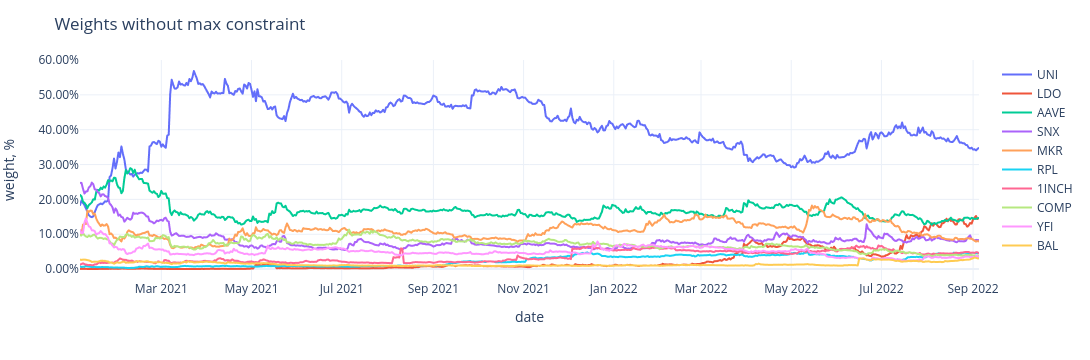

In [117]:
fig = px.line(weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    ## showlegend=False,
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights without max constraint'
)

### Adjust weights

This process adjusts weights to adhere to the weight constraints described in our methodology. In addition the `remove_tiny_weights` function checks for any assets with a weight below the minimum threshold of $0.5\%$ and proportionally increases all remaining weights (which are $> 0.5\%$). Note that after this procedure readjusting weights to respect maximum may be needed.

In [118]:
def adjust_weights(weights, max_weight):
    w = weights.copy()
    
    while (w > max_weight).any(axis=None):
        w[w > max_weight] = max_weight
        c = 1 - w.sum(axis=1)
        w_less = w[w < max_weight]
        w[(w < max_weight) & (w > 0)] += w_less.div(w_less.sum(axis=1), axis=0).mul(c, axis=0)
    
    return w

In [119]:
def remove_tiny_weights(weights, min_weight):
    w = weights.copy()
    
    w[w < min_weight] = 0
    w = w.div(w.sum(axis=1), axis=0)
    
    return w

In [120]:
adjusted_weights = adjust_weights(weights, max_weight=0.3) 
adjusted_weights = remove_tiny_weights(adjusted_weights, min_weight=0.005)
adjusted_weights = adjust_weights(adjusted_weights, max_weight=0.3)

adjusted_weights = adjusted_weights.sort_values(adjusted_weights.last_valid_index(),ascending=False, axis = 1)
# adjusted_weights

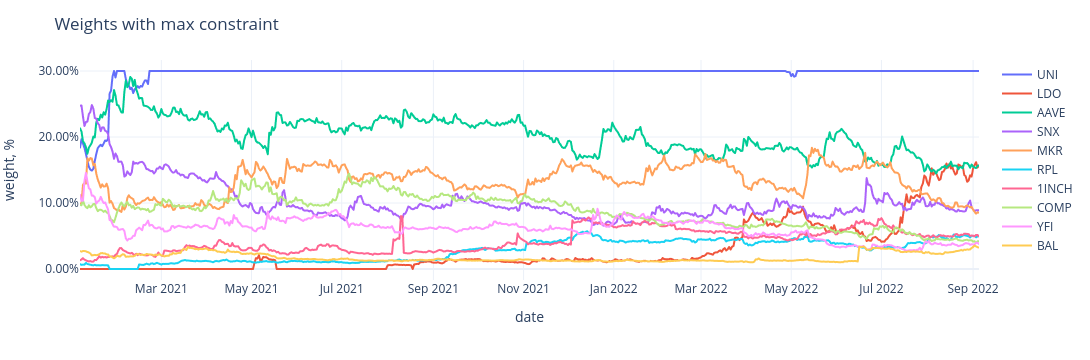

In [121]:
fig = px.line(adjusted_weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights with max constraint'
)

### Convert weights to the [1, 255] scale

On the contract side weights are integer numbers from the interval $[1, 255]$ with total sum $255$, so it's needed to convert retrieved weights to this format.

Note that one can't just round weights to integers after scaling, since it doesn't guarantee that their sum will be $255$. To fix that firstly floor function is applied to the weights and then $1$ is being added to the $k$ weights with largest fractional parts.

In [122]:
def convert_weights(weights):
    w_scaled = weights * 255
    w_res = np.floor(w_scaled).astype(int)    
    remainders = w_scaled - w_res    
    k = round(remainders.sum())
    w_below_max = w_res[w_res<76]
    for i in range(k):
        w_below_max[i] +=1
    for i in w_below_max.index:
        w_res[i] = w_below_max[i]
    return w_res

In [123]:
last_weights = adjusted_weights.iloc[-1].dropna()

In [124]:
converted_last_weights = convert_weights(last_weights)

## Summary table

In [125]:
pdi = pd.DataFrame()
pdi.index = chosen_tokens.index
pdi['name'] = chosen_tokens['name']
pdi['market_cap'] = marketcaps.iloc[-1].astype(int)
pdi['price'] = prices_data.iloc[-1]
pdi['weight'] = last_weights
pdi['weight_converted'] = converted_last_weights
pdi['address'] = [top_defi_tokens[symb]['address'] for symb in pdi.index]

pdi = pdi[pdi['weight'] > 0]
pdi = pdi.sort_values("market_cap",ascending=False)
pdi

,name,market_cap,price,weight,weight_converted,address
symbol,,,,,,
UNI,Uniswap,2950417551,6.465545,0.300000,76,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984
LDO,Lido DAO,1244169327,2.061793,0.157174,41,0x5a98fcbea516cf06857215779fd812ca3bef1b32
AAVE,Aave,1242115495,88.917963,0.156915,41,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9
SNX,Synthetix Network,705026312,2.980852,0.089065,23,0xc011a73ee8576fb46f5e1c5751ca3b9fe0af2a6f
MKR,Maker,675890325,750.879602,0.085384,22,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2
RPL,Rocket Pool,394285409,24.182996,0.049810,13,0xd33526068d116ce69f19a9ee46f0bd304f21a51f
1INCH,1inch,391438896,0.672971,0.049450,12,0x111111111117dc0aa78b770fa6a738034120c302
COMP,Compound,332538426,48.572619,0.042009,10,0xc00e94cb662c3520282e6f5717214004a7f26888
YFI,yearn.finance,298332825,9437.885427,0.037688,9,0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e
